In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
def return_tokens(processed_text):
    """
    Given a preprocessed string/instance, return its tokens and their counts.
    """
    token_counts = dict()
    
    if isinstance(processed_text, str):
        # Split the string into words/tokens
        processed_text = processed_text.split(" ")
        # Count the occurrences of each token
        for token in processed_text:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1
    else:
        # Empty string classified as a float for some reason
        token_counts = {"": 1}

    return token_counts

In [3]:
def find_vocabulary(data):
    """
    Find the list of every word which occurs in the  dataset (every word in textPreprocessed)
    """
    vocabulary = []

    for i in range(len(data)):
        processed_text = return_tokens(data.loc[i, "textPreprocessed"]).keys()
        vocabulary = vocabulary + list(processed_text)

    vocabulary = sorted(list(set(vocabulary)))
    return vocabulary

In [4]:
def find_count_matrix(data, vocabulary):
    """
    Find the count matrix, which is a matrix of size N*V where N is the number of instances in the training data 
    and V is the number of words in the vocabulary.  
    Each cell in the matrix represents the number of times a given word appeared in a given message 
    """

    N = len(data)
    V = len(vocabulary)

    # Intialise matrix N*V with 0s
    count_matrix = np.zeros((N,V))
    count_matrix = pd.DataFrame(count_matrix)
    count_matrix.columns = vocabulary

    # Iterate over each row - instance 
    for i in range(N):
        instance_token_counts = return_tokens(data.loc[i, "textPreprocessed"])
        for token in instance_token_counts.keys():
            count_matrix.loc[i, token] = instance_token_counts[token]
    
    return count_matrix

In [5]:
def find_prior_prob(data):
    """
    Returns a dictionary of the prior probability of each class P(class)
    """
    prior_probs = dict()

    labels = np.unique(data["class"])
    for label in labels:
        prior_probs[int(label)] = len(data[data["class"]==label])/len(data)

    return prior_probs

In [6]:
def calc_p_c_i(data, count_matrix, label, word, V=0, alpha=0):
    """
    p(word | label) = count(c,i) + alpha / total(c) + V*alpha
    count(c,i) is the total count of times word i appears in messages from class c
    total(c) is the total count of words in class c
    Alpha is smoothing factor used for Laplace smoothing, defaulted to 0 (no smoothing)
    V is the length of the count vector of a test instance
    """
    label_indexes = data[data["class"] == label].index
    count_matrix = count_matrix.iloc[label_indexes]
    word_counts = np.sum(count_matrix[word]) + alpha
    label_counts = np.sum(count_matrix, axis=0).sum() + (V*alpha)
    
    return float(word_counts / label_counts)

In [7]:
def find_conditional_prob(data, vocabulary, count_matrix):
    """
    Return dictionary conditional probabilities of each token in a class
    """
    conditional_probs = {int(label): None for label in data["class"].unique()}
    for label in conditional_probs.keys():
        conditional_probs[label] = {word: 0 for word in vocabulary}

        for word in vocabulary:
            conditional_probs[label][word] = calc_p_c_i(data, count_matrix, label, word, V=len(vocabulary), alpha=1)
    
    return conditional_probs

In [8]:
def find_posterior_prob(data, count_vector, vocabulary, prior_probs, conditional_probs):
    """
    Find posterior probability P(class = label | count = count vector) -> P(class = label) * P(count|c)
    """
    posterior_probs = {int(label): None for label in data["class"].unique()}
    for label in posterior_probs.keys():
        p_class = prior_probs[label]
        p_count_c = math.factorial(int(sum(count_vector))) / math.prod([math.factorial(int(x)) for x in count_vector])
        test_token_indexes = [i for i in range(len(count_vector)) if count_vector[i] != 0]

        for token_index in test_token_indexes:
            p_c_i = conditional_probs[label][vocabulary[token_index]]

            # Original formula
            p_count_c = p_count_c * math.pow(p_c_i, count_vector[token_index])

            # Or take log to avoid underflow
            # prob = math.pow(p_c_i, count_vector[token_index])
            # if prob == 0:
            #     p_count_c = p_count_c + 0
            # else:
            #     p_count_c = p_count_c + math.log(prob)
            
        p_c_count = p_class * p_count_c
        posterior_probs[label] = p_c_count

    return posterior_probs

In [9]:
def find_test_count_vector(test_text, vocabulary):
    """
    Find the count vector of a test instance
    """
    count_vector = np.zeros((1, len(vocabulary)))[0]
    test_token_counts = return_tokens(test_text)

    for i in range(len(vocabulary)):
        token = vocabulary[i]
        if token in test_token_counts.keys():
            count_vector[i] = test_token_counts[token]
    
    return count_vector

In [10]:
def classify_test_instance(data, vocabulary, test_text, prior_probs, conditional_probs):
    """
    Given a string, classify it as 0 - non malicious, or 1 - scam
    """
    test_count_vector = find_test_count_vector(test_text, vocabulary)

    # Count vector all zeroes so cannot classify
    if np.count_nonzero(test_count_vector) == 0:
        print("Cannot classify")
        print(test_text)
        return None
    
    test_posterior_prob = find_posterior_prob(data, test_count_vector, vocabulary, prior_probs, conditional_probs)
    # Find which class has higher likelihood
    best_label = None
    best_prob = 0

    # If both are equal, return 0.5, hard coded 
    if test_posterior_prob[0] == test_posterior_prob[1]:
        return 0.5

    for label, prob_label in test_posterior_prob.items():
        if prob_label > best_prob:
            best_prob = prob_label
            best_label = label
    
    return best_label

In [11]:
def create_model(data):
    vocabulary = find_vocabulary(data)
    count_matrix = find_count_matrix(data, vocabulary)
    prior_probs = find_prior_prob(data)
    conditional_probs = find_conditional_prob(data, vocabulary, count_matrix)

    return {"data": data,
            "vocabulary": vocabulary,
            "count_matrix": count_matrix,
            "prior_probs": prior_probs,
            "conditional_probs": conditional_probs}

In [12]:
def find_top_test_ratios(data, vocabulary, prior_probs, conditional_probs, c1, c2, boundary=False):
    ratios = dict()

    for test_text in data["textPreprocessed"]:
        test_count_vector = find_test_count_vector(test_text, vocabulary)
        test_posterior_prob = find_posterior_prob(data, test_count_vector, vocabulary, prior_probs, conditional_probs)
        post_c1 = test_posterior_prob[c1]
        post_c2 = test_posterior_prob[c2]

        if post_c2 != 0:
            r = post_c1/post_c2
            ratios[test_text] = r

    if not boundary:
        top_ratios = sorted(ratios.items(), key=lambda x: x[1], reverse=True)
    else:
        top_ratios = sorted(ratios.items(), key=lambda x: abs(x[1] - 1))

    top_ratios = dict(top_ratios)
    return top_ratios

In [13]:
def find_instance_confidence(model, unlabelled):
    data = model["data"]
    vocabulary = model["vocabulary"]
    count_matrix = model["count_matrix"]
    prior_probs = model["prior_probs"]
    conditional_probs = model["conditional_probs"]

    # Find R scores for each of the unlabelled instances

    # Confidence of scam
    scam_confidence = find_top_test_ratios(unlabelled, vocabulary, prior_probs, conditional_probs, c1=1, c2=0)
    # Confidence of non-malicious
    non_mal_confidence = find_top_test_ratios(unlabelled, vocabulary, prior_probs, conditional_probs, c1=0, c2=1)
    
    return scam_confidence, non_mal_confidence

In [ ]:
def get_top_confidence(unlabelled, num_scam, num_non_mal):
    # print(len(unlabelled)) # 1999, dropped 1 instance due to not having tokens in vocab
    confident_scam_instances = unlabelled[unlabelled["Scam confidence"] > 1]
    confident_non_mal_instances = unlabelled[unlabelled["Non-malicious confidence"] > 1]

    # Get the indexes of the top scam confidence values
    top_scam_idx = confident_scam_instances.nlargest(num_scam, "Scam confidence").index
    
    # Get the indexes of the top non-malicious confidence values
    top_non_mal_idx = confident_non_mal_instances.nlargest(num_non_mal, "Non-malicious confidence").index

    confident_idx = list(set(top_scam_idx).union(top_non_mal_idx))
    print(1)
    unlabelled = unlabelled.iloc[confident_idx]
    print(2)

    return unlabelled

In [15]:
def predict_dataset(model, test):
    test_instances = test["textPreprocessed"]
    
    vocabulary = model["vocabulary"]
    prior_probs = model["prior_probs"]
    conditional_probs = model["conditional_probs"]
    
    predicted_labels = []
    for test_instance in test_instances:
        predicted_label = classify_test_instance(test, vocabulary, test_instance, prior_probs, conditional_probs)
        predicted_labels.append(predicted_label)

    test["predicted class"] = predicted_labels

    return test

In [16]:
def report_predictions(test):
    test_no_draws = test[test["predicted class"] != 0.5]
    class_true = test_no_draws["class"]
    class_predict = test_no_draws["predicted class"]
    print(classification_report(class_true, class_predict))
    cm = confusion_matrix(class_true, class_predict)
    print(cm)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
def pipeline(train_data, unlabelled_data, test_data, confident_prop):
    
    # Create training model based on training data
    train_model = create_model(train_data)

    # Use the model to get most confident instances from unlabelled data
    if unlabelled_data is not None:
        scam_confidence, non_mal_confidence = find_instance_confidence(train_model, unlabelled_data)
        unlabelled_data["Scam confidence"] = unlabelled_data["textPreprocessed"].apply(lambda x: scam_confidence.get(x, None))
        unlabelled_data["Non-malicious confidence"] = unlabelled_data["textPreprocessed"].apply(lambda x: non_mal_confidence.get(x,None))
        
        top_instances = int(confident_prop * len(unlabelled_data))
        confident_unlabelled = get_top_confidence(unlabelled_data, top_instances, top_instances)
        
        expanded_data = pd.concat([train_data, confident_unlabelled[["textOriginal", "textPreprocessed", "class"]]], axis=0)
        expanded_data.reset_index(drop=True, inplace=True)

        # Create expanded model based on supervised data and unlabelled data
        model = create_model(expanded_data)
        test_data = predict_dataset(model, test_data)
    
    # No validation and unlabelled
    else:
        model = train_model
        test_data = predict_dataset(train_model, test_data)

    report_predictions(test_data)

    return model

In [18]:
all_train = pd.read_csv("sms_supervised_train.csv")
test = pd.read_csv("sms_test.csv")
unlabelled = pd.read_csv("sms_unlabelled.csv")

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       800
           1       0.93      0.95      0.94       200

    accuracy                           0.97      1000
   macro avg       0.96      0.97      0.96      1000
weighted avg       0.98      0.97      0.98      1000

[[785  15]
 [ 10 190]]


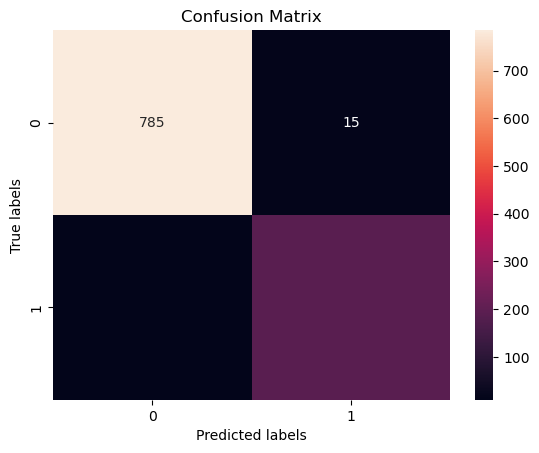

In [19]:
# Model performance when not using unlabelled + validation
supervised_model = pipeline(train_data=all_train, unlabelled_data=None, test_data=test, confident_prop=0)

In [20]:
train, validation = train_test_split(all_train, test_size=0.2, random_state=1, stratify=all_train['class'])
train.reset_index(inplace=True, drop=True)
validation.reset_index(inplace=True, drop=True)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       320
           1       0.93      0.95      0.94        80

    accuracy                           0.97       400
   macro avg       0.96      0.97      0.96       400
weighted avg       0.98      0.97      0.98       400

[[314   6]
 [  4  76]]


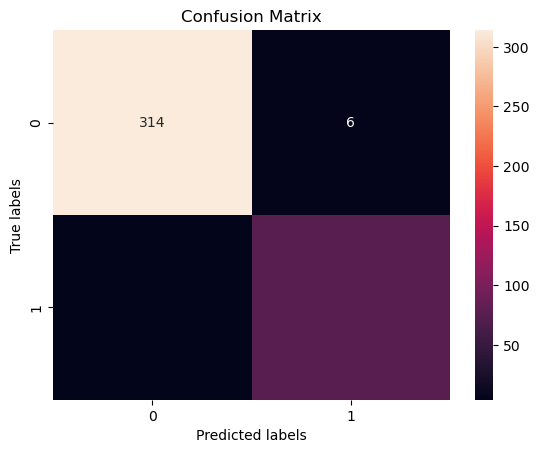

In [21]:
# Model performance when using subset of train, and testing on validation set, baseline, technically not semi supervised yet as have no incoporated unlabelled data
semi_model_0 = pipeline(train_data=train, unlabelled_data=None, test_data=validation, confident_prop=1)

1
2
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       320
           1       0.94      0.93      0.93        80

    accuracy                           0.97       400
   macro avg       0.96      0.95      0.96       400
weighted avg       0.97      0.97      0.97       400

[[315   5]
 [  6  74]]


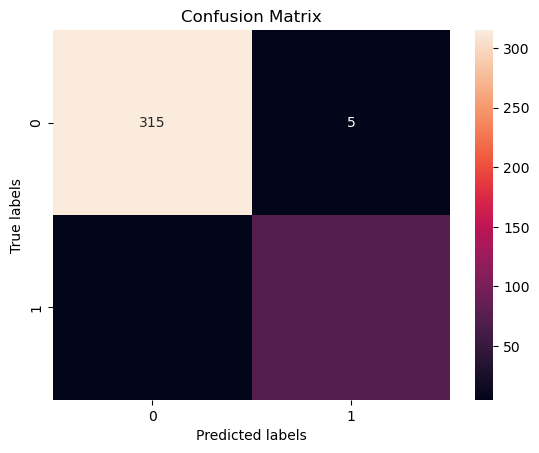

{'data':                                            textOriginal  \
 0     Give her something to drink, if she takes it a...   
 1     In other news after hassling me to get him wee...   
 2     He's just gonna worry for nothing. And he won'...   
 3     I'm nt goin, got somethin on, unless they meet...   
 4     Tell my  bad character which u Dnt lik in me. ...   
 ...                                                 ...   
 3593            Yes :)it is completely in out of form:)   
 3594             Still otside le..u come 2morrow maga..   
 3595                    Kay... Since we are out already   
 3596   call now 08707509020 Just 20p per min NTT Ltd...   
 3597            Are you angry with me. What happen dear   
 
                                        textPreprocessed  class  
 0     . . , know take may let give vomit something d...      0  
 1                            . get week news weed money      0  
 2         . . go he 's just give to nothing worry money      0  
 3    

In [24]:
# Model performance when using subset of train, due to splitting of validation set, + unlabelled data to create semi-supervised model
pipeline(train_data=train, unlabelled_data=unlabelled, test_data=validation, confident_prop=1)

In [ ]:
# From above, which performed best on validation when adjusting the top_proportion parameter
# Use that best model to evaluate test dataset